# Classification des documents du procès des groupes américains du tabac

Ben Hamadi Yamin

Nous avons une base de données de documents de différentes natures. Le but de ce notebook est d'essayer de classifier au mieux les documents en fonction de leurs catégories.

In [47]:
import pandas as pd
import numpy as np
import csv
import glob
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/yamin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yamin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
path_csv = "Tobacco3482.csv"

# Etude des classes

In [22]:
df =pd.read_csv(path_csv)
df.iloc[:3]

,img_path,label
0,Advertisement/0000136188.jpg,Advertisement
1,Advertisement/0000435350.jpg,Advertisement
2,Advertisement/0000556056.jpg,Advertisement


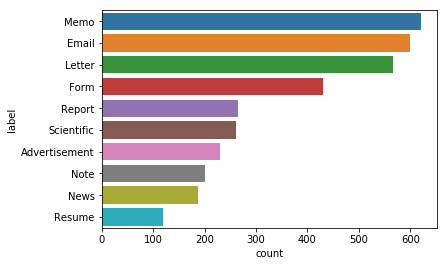

In [23]:
sns.countplot(data=df,y='label', order = df['label'].value_counts().index)
plt.show()

Commentaire : Il y'a 10 catégories de document avec une prédominance de fichier memo, de lettre et d'email.

# Récupération des chemins vers les fichiers txt

In [24]:
def recup_chemin(df):
    chemin_img = df["img_path"]
    chemin_txt = []
    chemin_txt = []
    for elem in chemin_img:
        chemin_txt.append(elem.replace('jpg', 'txt'))
        
    return chemin_txt

chemin_txt = recup_chemin(df)
print("Nombre de chemins : ", len(chemin_txt))

Nombre de chemins :  3482


# Récupération des fichiers txt

In [25]:
def recup_fichier_txt(chemin_txt):
    list_fichiers = []
    for chemin in chemin_txt:
        with open("Tobacco3482-OCR/"+chemin, 'r') as fichier:
            list_fichiers.append(fichier.read().replace('\n', ''))
    print(" Si nous avons récupérer le bon nombre de documents (3482): ", len(list_fichiers))
    
    return list_fichiers

list_fichiers = recup_fichier_txt(chemin_txt)
#print("\nAffichage d'un fichier aléatoire : \n\n", list_fichiers[int(np.random.rand(1) * len(list_fichiers))])

#Conversion sous format df
for i, content in enumerate(list_fichiers):  
    df.loc[i, 'img_path'] = content
    
#Vérification de la base de données
#df.iloc[:3]

 Si nous avons récupérer le bon nombre de documents (3482):  3482


In [26]:
#Division du dataset 
def split_dataset(X,y):

    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_dataset(X=df.img_path,y=df.label)
    
print("Taille de X_train : ", len(X_train))
print("Taille de X_test : ", len(X_test))

Taille de X_train :  2332
Taille de X_test :  1150


# Naif bayes classifier

Commencons par utiliser un classifieur simple et sans prétraitement des données.

In [27]:
#Nous allons considèrer les mots par leurs fréquences

vectorizer = CountVectorizer(max_features=3000)
vectorizer.fit(X_train)
X_train_counts = vectorizer.transform(X_train)
X_test_counts = vectorizer.transform(X_test)

In [28]:
# train a Naive Bayes classifier


clf = MultinomialNB()
clf.fit(X_train_counts, y_train)

print("Naive Bayes Score durant la phase de test : ", clf.score(X_test_counts,y_test))
print("Naive Bayes Score durant la phase d'entrainement : ", clf.score(X_train_counts,y_train))

Naive Bayes Score durant la phase de test :  0.7147826086956521
Naive Bayes Score durant la phase d'entrainement :  0.8267581475128645


In [29]:
y_pred_test = clf.predict(X_test_counts)
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

               precision    recall  f1-score   support

Advertisement       0.64      0.69      0.66        84
        Email       0.91      0.93      0.92       209
         Form       0.74      0.81      0.77       149
       Letter       0.70      0.71      0.71       182
         Memo       0.59      0.71      0.64       186
         News       0.70      0.79      0.74        61
         Note       0.59      0.24      0.34        67
       Report       0.53      0.46      0.49        84
       Resume       0.97      0.97      0.97        38
   Scientific       0.75      0.53      0.62        90

  avg / total       0.71      0.71      0.71      1150

[[ 58   1   7   2   9   4   2   1   0   0]
 [  0 194   0   5   5   3   0   2   0   0]
 [ 13   2 120   2   5   0   5   0   0   2]
 [  1   1   2 130  30   3   0  13   0   2]
 [  1  10   4  28 132   3   0   6   0   2]
 [  4   1   2   0   2  48   2   0   0   2]
 [ 11   5  10   6  18   0  16   1   0   0]
 [  1   0   5  12  12   7   0  39   

# Prétraitement des données (Stop words)

In [30]:
def without_stop_words(list_fichiers):

    dfs = pd.read_csv(path_csv)
    stop_words = set(stopwords.words('english'))
    list_preprocess = []
    for fichier in list_fichiers:
        preprocess = []
        words = word_tokenize(fichier)
        for mot in words:
            if mot not in stop_words:

                preprocess.append(mot)
        str_preprocess = ' '.join(preprocess)# Pour retourner sur une phrase et non une liste
        list_preprocess.append(str_preprocess)
    for i, content in enumerate(list_preprocess):  
        dfs.loc[i, 'img_path'] = content

        
    return dfs

Les stop words peuvent poser problème lorsque que l'on veut classifier les documents à partir de la fréquence d'appartions des mots. Car ce sont les mots les plus communs et ils peuvent empecher d'autres mots plus discriminateur d'avoir un poids suffisant dans la classification.

In [31]:
dfs = without_stop_words(list_fichiers)
X_train, X_test, y_train, y_test = split_dataset(X=dfs.img_path,y=dfs.label)
vectorizer = CountVectorizer(max_features=3000)
vectorizer.fit(X_train)
X_train_countsSW = vectorizer.transform(X_train)
X_test_countsSW = vectorizer.transform(X_test)

In [32]:
# train a Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train_countsSW, y_train)

print("Naive Bayes SW Score durant la phase de test : ", clf.score(X_test_countsSW,y_test))
print("Naive Bayes SW Score durant la phase d'entrainement : ", clf.score(X_train_countsSW,y_train))

Naive Bayes SW Score durant la phase de test :  0.7095652173913043
Naive Bayes SW Score durant la phase d'entrainement :  0.8331903945111492


In [34]:
y_pred_test = clf.predict(X_test_countsSW)
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

               precision    recall  f1-score   support

Advertisement       0.62      0.71      0.67        84
        Email       0.92      0.94      0.93       209
         Form       0.72      0.79      0.75       149
       Letter       0.67      0.68      0.67       182
         Memo       0.60      0.74      0.66       186
         News       0.66      0.79      0.72        61
         Note       0.48      0.16      0.24        67
       Report       0.54      0.44      0.49        84
       Resume       1.00      0.97      0.99        38
   Scientific       0.76      0.53      0.63        90

  avg / total       0.71      0.71      0.70      1150

[[ 60   0   6   1   8   5   3   1   0   0]
 [  0 196   1   5   3   2   0   2   0   0]
 [ 14   2 118   2   8   1   3   0   0   1]
 [  0   1   5 123  30   6   1  14   0   2]
 [  1   8   4  26 138   2   2   4   0   1]
 [  5   1   1   0   2  48   2   0   0   2]
 [ 11   4  12   7  20   0  11   0   0   2]
 [  2   0   4  17  11   6   0  37   

Les stop words ne semblent pas avoir d'impact négatif sur la phase de test.

# TF-IDF REPRESENTATION

Une autre méthode pour éviter les stop words est d'utiliser une réprésentation TF-IDF. Cette représentation va permettre de décrire un mot par son contexte au sein du document.

In [35]:
from sklearn.feature_extraction.text import TfidfTransformer


tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_Tfid = tf_transformer.transform(X_train_counts)
X_test_Tfid = tf_transformer.transform(X_test_counts)

In [36]:
clf = MultinomialNB()
clf.fit(X_train_Tfid, y_train)

y_pred_test = clf.predict(X_test_Tfid)

print("TF-IDF Score durant la phase de test : ", clf.score(X_test_counts,y_test))
print("TF-IDF Score durant la phase d'entrainement : ", clf.score(X_train_counts,y_train))

TF-IDF Score durant la phase de test :  0.577391304347826
TF-IDF Score durant la phase d'entrainement :  0.6582332761578045


Voyons à présent quelle catégorie pose le plus de problème à classifier.

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

               precision    recall  f1-score   support

Advertisement       0.96      0.32      0.48        84
        Email       0.89      0.92      0.90       209
         Form       0.64      0.75      0.69       149
       Letter       0.49      0.73      0.58       182
         Memo       0.42      0.83      0.56       186
         News       1.00      0.25      0.39        61
         Note       0.00      0.00      0.00        67
       Report       1.00      0.01      0.02        84
       Resume       1.00      0.95      0.97        38
   Scientific       0.85      0.31      0.46        90

  avg / total       0.68      0.61      0.56      1150

[[ 27   4  19  13  21   0   0   0   0   0]
 [  0 193   0   7   9   0   0   0   0   0]
 [  0   2 112   5  29   0   0   0   0   1]
 [  0   1   0 132  49   0   0   0   0   0]
 [  0   7   1  23 155   0   0   0   0   0]
 [  0   1   6  30   9  15   0   0   0   0]
 [  1   9  21   9  27   0   0   0   0   0]
 [  0   0   3  36  40   0   0   1   

/home/yamin/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Avec une représentation TF-IDF le classifieurs naives bayes à du mal à apposer le label sur les fichiers "Note" et "Report".
Ces fichiers peuvent être très différents de par leurs formes et leurs mots. Ce qui rend difficile sa classification en fonction d'un contexte.

# Random Forest

Les forêts aléatoires ont beaucoup d'hyperparamètres. Testons dans un premier temps avec les paramètres par défaut.

In [43]:
dfs = without_stop_words(list_fichiers)
X_train, X_test, y_train, y_test = split_dataset(X=dfs.img_path,y=dfs.label)

In [45]:
#Nous allons considèrer les mots par leurs fréquences

vectorizer = CountVectorizer(max_features=3000)
vectorizer.fit(X_train)
X_train_counts = vectorizer.transform(X_train)
X_test_counts = vectorizer.transform(X_test)

### Avec cross Validation

In [50]:
clf_rf = RandomForestClassifier(n_estimators=100)
score_test = cross_val_score(clf_rf,X_test_counts,y_test,cv=5)
score_train = cross_val_score(clf_rf,X_train_counts,y_train,cv=5)
print("Random Forest Score durant la phase de test : %0.2f (+/- %0.2f)" % (score_test.mean(), score_test.std() * 2))
print("Random Forest Score durant la phase d'entrainement : %0.2f (+/- %0.2f)" % (score_train.mean(), score_train.std() * 2))

Random Forest Score durant la phase de test : 0.68 (+/- 0.06)
Random Forest Score durant la phase d'entrainement : 0.72 (+/- 0.05)


# Recherche du nombre d'arbre

In [51]:
list_scores=[]
absc=[]
std_list=[]
for i in range (1,1000,200):
    clf_rf = RandomForestClassifier(n_estimators=i)
    score = cross_val_score(clf_rf, X_train_counts, y_train, cv=5)
    list_scores.append(np.mean(score))
    std_list.append(np.std(score))
    absc.append(i)


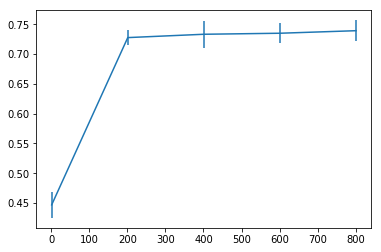

In [52]:

plt.errorbar(absc,list_scores,std_list)
plt.show()

In [ ]:
# Source : https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# get some data
X = X_train_counts
y = y_train
# build a classifier
clf = RandomForestClassifier(n_estimators=570)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

In [56]:
clf_rf = RandomForestClassifier(n_estimators=800)
clf_rf.fit(X_train_counts, y_train)

y_pred_test = clf_rf.predict(X_test_counts)
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

               precision    recall  f1-score   support

Advertisement       0.78      0.50      0.61        84
        Email       0.88      0.96      0.92       209
         Form       0.70      0.76      0.73       149
       Letter       0.65      0.77      0.71       182
         Memo       0.70      0.83      0.76       186
         News       0.98      0.72      0.83        61
         Note       0.42      0.70      0.53        67
       Report       0.71      0.26      0.38        84
       Resume       1.00      0.97      0.99        38
   Scientific       0.88      0.47      0.61        90

  avg / total       0.75      0.73      0.72      1150

[[ 42   1   5   6   0   0  29   1   0   0]
 [  0 200   1   3   2   0   3   0   0   0]
 [  1   7 113   3   7   0  18   0   0   0]
 [  3   3   1 141  29   0   3   2   0   0]
 [  0   9   4  14 154   0   4   1   0   0]
 [  1   1   6   4   2  44   2   1   0   0]
 [  5   3   4   2   6   0  47   0   0   0]
 [  0   1  10  32  11   1   1  22   